In [18]:
import os
import pandas as pd
from tensorflow.keras import Input, regularizers, Model
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Concatenate, Dropout, LSTM, GRU
from tensorflow.keras.layers import Input, Embedding, GlobalAveragePooling1D, Dense, Dropout, Concatenate, Reshape
from tensorflow.keras.optimizers import Adam, AdamW, RMSprop, SGD, Adadelta, Adagrad, Nadam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
from google.colab import files

uploaded = files.upload()

Saving fasttext.pickle to fasttext.pickle


In [3]:
df = pd.read_pickle('fasttext.pickle')

In [4]:
df.head()

,Unnamed: 0,User review,Review date,Star review,Text length,Has media,Has answer,Written by bot
0,0,"[0.025498182, -0.018170398, 0.046447996, -0.02...",2024-10-09,5,54,0,0,0
1,1,"[0.011105347, -0.008842508, 0.021998996, 0.018...",2024-10-09,5,195,0,0,0
2,2,"[0.013566197, 0.004024408, 0.029151376, -0.037...",2024-10-09,5,17,0,0,0
3,3,"[0.004013102, -0.0022078655, 0.0066413223, 0.0...",2024-10-09,5,33,0,0,0
4,4,"[0.071841806, 0.012794206, 0.05186933, -0.0082...",2024-10-09,5,15,0,0,0


In [5]:
del df['Review date']

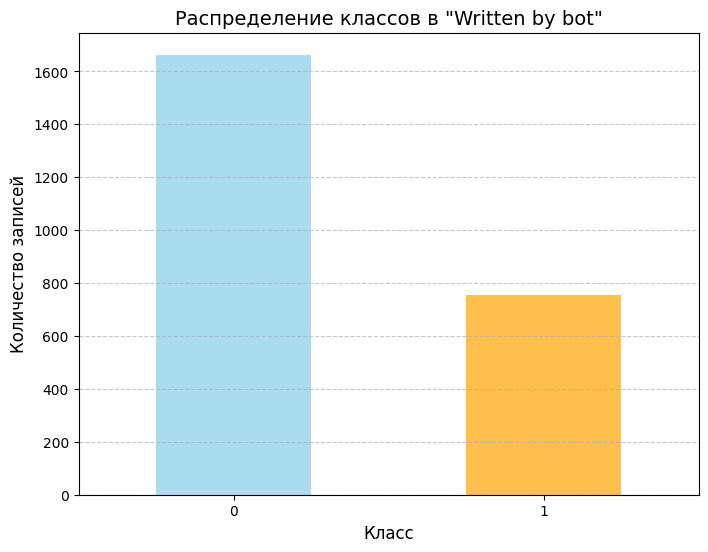

In [6]:
df_balance = df.copy()
class_counts = df['Written by bot'].value_counts()
plt.figure(figsize=(8, 6))
class_counts.plot(kind='bar', color=['skyblue', 'orange'], alpha=0.7)
plt.title('Распределение классов в "Written by bot"', fontsize=14)
plt.xlabel('Класс', fontsize=12)
plt.ylabel('Количество записей', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [7]:
df.columns = df.columns.str.strip()
df = df.drop(columns=['Unnamed: 0.1', 'Unnamed: 0'], errors='ignore')

In [8]:
df['Has media'] = df['Has media'].replace({'True': '1', 'False': '0'})
df['Has media'].value_counts()

,count
Has media,
0,1699
1,717


In [9]:
y = df['Written by bot']
X = df.drop(columns=['Written by bot']).values

In [10]:
y, X = df['Written by bot'], df.drop(columns=['Written by bot'])

Исходное распределение классов: Counter({0: 1663, 1: 753})


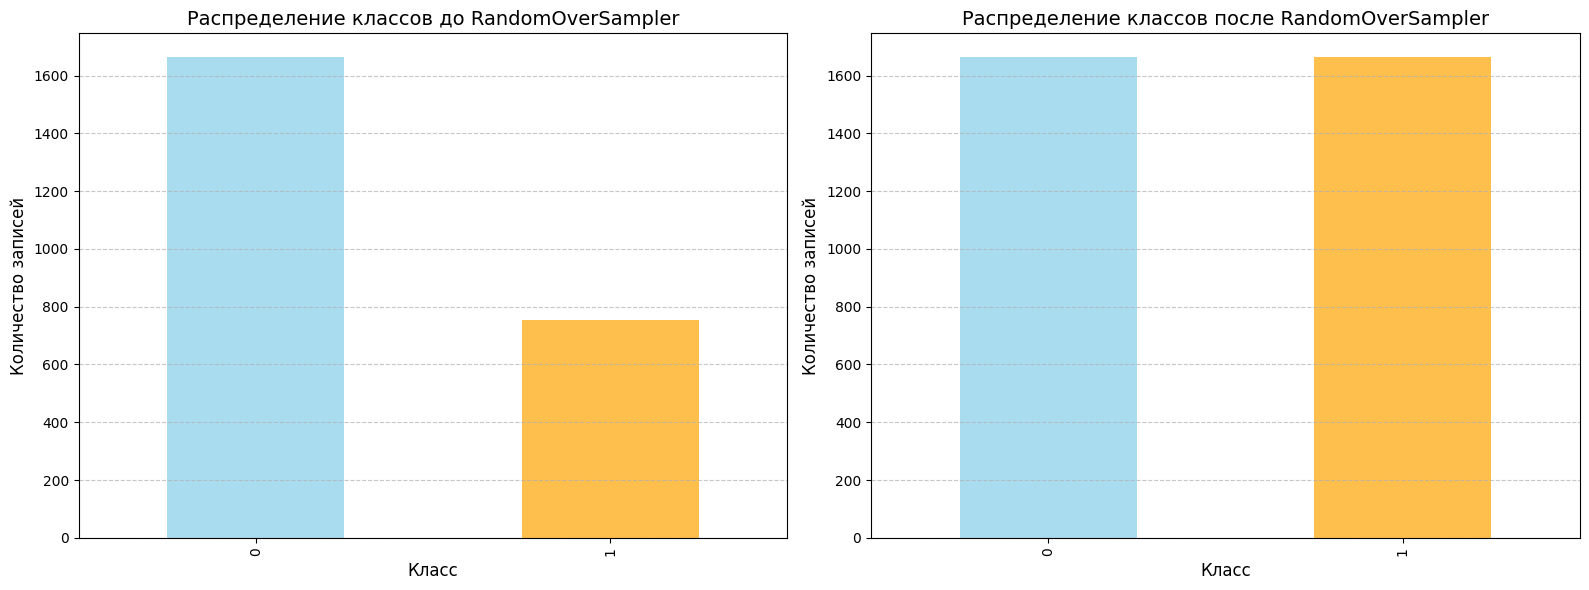

In [11]:
print("Исходное распределение классов:", Counter(y))

ros = RandomOverSampler(random_state=42)
X_ros, y_ros = ros.fit_resample(X, y)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

class_counts_before = y.value_counts()
class_counts_before.plot(kind='bar', color=['skyblue', 'orange'], alpha=0.7, ax=axes[0])
axes[0].set_title('Распределение классов до RandomOverSampler', fontsize=14)
axes[0].set_xlabel('Класс', fontsize=12)
axes[0].set_ylabel('Количество записей', fontsize=12)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

class_counts_after = pd.Series(y_ros).value_counts()
class_counts_after.plot(kind='bar', color=['skyblue', 'orange'], alpha=0.7, ax=axes[1])
axes[1].set_title('Распределение классов после RandomOverSampler', fontsize=14)
axes[1].set_xlabel('Класс', fontsize=12)
axes[1].set_ylabel('Количество записей', fontsize=12)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [12]:
import tensorflow as tf
X_ros_df = pd.DataFrame(X_ros, columns=df.drop(columns=['Written by bot']).columns)
X_ros_df['User review'] = X_ros_df['User review']
X_ros_text = X_ros_df['User review']
X_ros_text = np.array(X_ros_text.tolist(), dtype=np.float32)
X_ros_text_padded = tf.keras.preprocessing.sequence.pad_sequences(
    X_ros_text, maxlen=1000, padding='post', truncating='post'
)
X_ros_numeric = X_ros_df.drop(columns=['User review'])
X_ros_numeric = np.array(X_ros_numeric, dtype=np.float32)

In [13]:
X_train_text, X_test_text, X_train_num, X_test_num, y_train, y_test = train_test_split(
    X_ros_text, X_ros_numeric, y_ros, test_size=0.2, random_state=42, stratify=y_ros
)

print(f"Размеры текстовых данных:")
print(f"X_train_text: {X_train_text.shape}, X_test_text: {X_test_text.shape}")
print(f"Размеры числовых данных:")
print(f"X_train_num: {X_train_num.shape}, X_test_num: {X_test_num.shape}")
print(f"Размеры меток:")
print(f"y_train: {y_train.shape}, y_test: {y_test.shape}")

Размеры текстовых данных:
X_train_text: (2660, 300), X_test_text: (666, 300)
Размеры числовых данных:
X_train_num: (2660, 4), X_test_num: (666, 4)
Размеры меток:
y_train: (2660,), y_test: (666,)


In [14]:
X_train_text = tf.convert_to_tensor(X_train_text, dtype=tf.float32)
X_train_num = tf.convert_to_tensor(X_train_num, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.int32)

X_test_text = tf.convert_to_tensor(X_test_text, dtype=tf.float32)
X_test_num = tf.convert_to_tensor(X_test_num, dtype=tf.float32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.int32)

In [15]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 7.5 MB/s eta 0:00:00


In [16]:
import keras_tuner as kt

In [20]:
def build_model(hp):
    text_input = Input(shape=(300,), name='text_input')
    activation_choice = hp.Choice('activation', ['relu', 'swish', 'leaky_relu'])

    if activation_choice == 'leaky_relu':
        activation = tf.keras.layers.LeakyReLU(alpha=0.1)
    else:
        activation = activation_choice

    x_text = Dense(hp.Int('dense_units', 16, 128, 16), activation=activation)(text_input)

    num_input = Input(shape=(4,), name='num_input')
    x_num = Dense(32, activation=activation)(num_input)

    combined = Concatenate()([x_text, x_num])
    x = combined

    for i in range(hp.Int('num_layers', 1, 10)):
        reg_type = hp.Choice(f'reg_type_{i}', ['l1', 'l2', 'l1_l2'])
        reg_value = hp.Float(f'reg_value_{i}', 0.001, 0.1, 0.001)

        if reg_type == 'l1':
            reg = regularizers.l1(reg_value)
        elif reg_type == 'l2':
            reg = regularizers.l2(reg_value)
        else:
            reg = regularizers.l1_l2(l1=reg_value, l2=reg_value)

        x = Dense(hp.Int(f'units_{i}', 64, 256, 64), activation=activation, kernel_regularizer=reg)(x)
        x = Dropout(hp.Float(f'dropout_{i}', 0.1, 0.5, 0.1))(x)

    output = Dense(2, activation='softmax')(x)

    optimizer_choice = hp.Choice('optimizer', ['adam', 'adamw', 'rmsprop', 'sgd', 'adadelta', 'adagrad', 'nadam'])
    if optimizer_choice == 'adam':
        optimizer = Adam()
    elif optimizer_choice == 'adamw':
        optimizer = AdamW()
    elif optimizer_choice == 'rmsprop':
        optimizer = RMSprop()
    elif optimizer_choice == 'adadelta':
        optimizer = Adadelta()
    elif optimizer_choice == 'adagrad':
        optimizer = Adagrad()
    elif optimizer_choice == 'nadam':
        optimizer = Nadam()
    else:
        optimizer = SGD()

    model = Model(inputs=[text_input, num_input], outputs=output)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Настройка гиперпараметров
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='my_tuner_dir',
    project_name='text_num_classification'
)

# Поиск лучших гиперпараметров
tuner.search(
    [X_train_text, X_train_num], y_train,
    validation_data=([X_test_text, X_test_num], y_test),
    epochs=10,
    batch_size=32,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)

# Получение наилучшей модели
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hps)

# Обучение лучшей модели
history = best_model.fit(
    [X_train_text, X_train_num], y_train,
    validation_data=([X_test_text, X_test_num], y_test),
    epochs=50,
    batch_size=32,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)

# Оценка модели на тестовой выборке
test_loss, test_acc = best_model.evaluate([X_test_text, X_test_num], y_test)
print(f"Тестовая точность: {test_acc:.4f}")

# Сохранение обученной модели
best_model.save("fasttext_model_vanilla.h5")

Reloading Tuner from my_tuner_dir/text_num_classification/tuner0.json
Epoch 1/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.4921 - loss: 85.9870 - val_accuracy: 0.6021 - val_loss: 23.6403
Epoch 2/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5344 - loss: 15.6806 - val_accuracy: 0.6577 - val_loss: 4.8959
Epoch 3/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5611 - loss: 4.0077 - val_accuracy: 0.5000 - val_loss: 2.1901
Epoch 4/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5805 - loss: 1.9407 - val_accuracy: 0.5000 - val_loss: 1.4245
Epoch 5/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5562 - loss: 1.3407 - val_accuracy: 0.6967 - val_loss: 1.1497
Epoch 6/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5937 - loss: 1.1266 - val_accuracy: 0.5165 - val_loss: 1.0723
Epoch 7/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5952 - loss: 1.0532 - val_accuracy: 0.5000 - val_loss: 1.0186
Epoch 8/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/

Тестовая точность: 0.9685


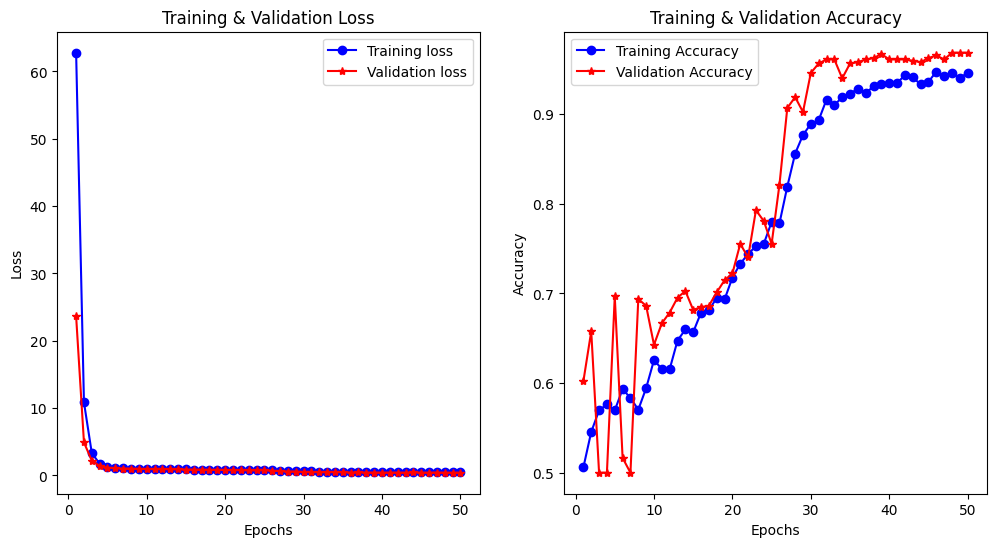

In [21]:
import matplotlib.pyplot as plt

history_dict = history.history

train_loss = history_dict['loss']
val_loss = history_dict['val_loss']

train_acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

epochs = range(1, len(train_loss) + 1)

# График потерь
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'r*-', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

# График точности
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r*-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

plt.show()


In [22]:
from google.colab import files
files.download("fasttext_model_vanilla.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Pooling

In [24]:
import keras_tuner as kt

def build_model(hp):
    text_input = Input(shape=(300,), name='text_input')
    activation_choice = hp.Choice('activation', ['relu', 'swish', 'leaky_relu'])

    if activation_choice == 'leaky_relu':
        activation = tf.keras.layers.LeakyReLU(alpha=0.1)
    else:
        activation = activation_choice

    x_text = Dense(hp.Int('dense_units', 16, 128, 16), activation=activation)(text_input)
    x_text = tf.keras.layers.Reshape((-1, 1))(x_text)
    num_pooling_layers = hp.Int('num_pooling_layers_text', 1, 5)
    for _ in range(num_pooling_layers):
        x_text = GlobalAveragePooling1D()(x_text)

    num_input = Input(shape=(4,), name='num_input')
    x_num = Dense(32, activation=activation)(num_input)
    x_num = tf.keras.layers.Reshape((-1, 1))(x_num)

    num_pooling_layers = hp.Int('num_pooling_layers_num', 1, 5)
    for _ in range(num_pooling_layers):
        x_num = GlobalAveragePooling1D()(x_num)

    combined = Concatenate()([x_text, x_num])
    x = combined

    for i in range(hp.Int('num_layers', 1, 10)):
        reg_type = hp.Choice(f'reg_type_{i}', ['l1', 'l2', 'l1_l2'])
        reg_value = hp.Float(f'reg_value_{i}', 0.001, 0.1, 0.001)

        if reg_type == 'l1':
            reg = regularizers.l1(reg_value)
        elif reg_type == 'l2':
            reg = regularizers.l2(reg_value)
        else:
            reg = regularizers.l1_l2(l1=reg_value, l2=reg_value)

        x = Dense(hp.Int(f'units_{i}', 64, 256, 64), activation=activation, kernel_regularizer=reg)(x)
        x = Dropout(hp.Float(f'dropout_{i}', 0.1, 0.5, 0.1))(x)

    output = Dense(2, activation='softmax')(x)

    optimizer_choice = hp.Choice('optimizer', ['adam', 'adamw', 'rmsprop', 'sgd', 'adadelta', 'adagrad', 'nadam'])
    optimizers = {
        'adam': Adam(), 'adamw': AdamW(), 'rmsprop': RMSprop(),
        'adadelta': Adadelta(), 'adagrad': Adagrad(), 'nadam': Nadam(), 'sgd': SGD()
    }
    optimizer = optimizers[optimizer_choice]

    model = Model(inputs=[text_input, num_input], outputs=output)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Настройка гиперпараметров
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='my_tuner_dir',
    project_name='text_num_classification'
)

# Поиск лучших гиперпараметров
tuner.search(
    [X_train_text, X_train_num], y_train,
    validation_data=([X_test_text, X_test_num], y_test),
    epochs=10,
    batch_size=32,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)

# Получение наилучшей модели
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hps)

# Обучение лучшей модели
history = best_model.fit(
    [X_train_text, X_train_num], y_train,
    validation_data=([X_test_text, X_test_num], y_test),
    epochs=50,
    batch_size=32,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)

# Оценка модели на тестовой выборке
test_loss, test_acc = best_model.evaluate([X_test_text, X_test_num], y_test)
print(f"Тестовая точность: {test_acc:.4f}")

# Сохранение обученной модели
best_model.save("fasttext_model_pooling.h5")

Reloading Tuner from my_tuner_dir/text_num_classification/tuner0.json
Epoch 1/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.4989 - loss: 77.6201 - val_accuracy: 0.5000 - val_loss: 13.8610
Epoch 2/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5081 - loss: 6.9952 - val_accuracy: 0.4625 - val_loss: 0.9407
Epoch 3/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4923 - loss: 0.9212 - val_accuracy: 0.5000 - val_loss: 0.9034
Epoch 4/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4976 - loss: 0.9025 - val_accuracy: 0.5000 - val_loss: 0.8973
Epoch 5/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4809 - loss: 0.8975 - val_accuracy: 0.4955 - val_loss: 0.8931
Epoch 6/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4844 - loss: 0.8927 - val_accuracy: 0.5000 - val_loss: 0.8890
Epoch 7/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5043 - loss: 0.8891 - val_accuracy: 0.5000 - val_loss: 0.8860
Epoch 8/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/

Тестовая точность: 0.5000


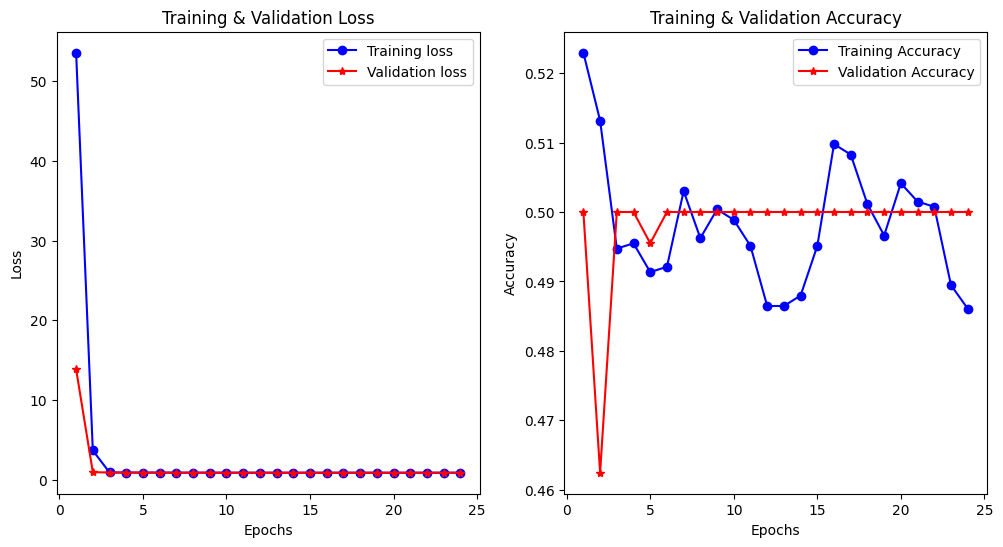

In [25]:
import matplotlib.pyplot as plt

history_dict = history.history

train_loss = history_dict['loss']
val_loss = history_dict['val_loss']

train_acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

epochs = range(1, len(train_loss) + 1)

# График потерь
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'r*-', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

# График точности
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r*-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

plt.show()


In [26]:
from google.colab import files
files.download("fasttext_model_pooling.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# LSTM

In [28]:
def build_model(hp):
    text_input = Input(shape=(300,), name='text_input')
    activation_choice = hp.Choice('activation', ['relu', 'swish', 'leaky_relu'])

    if activation_choice == 'leaky_relu':
        activation = tf.keras.layers.LeakyReLU(alpha=0.1)
    else:
        activation = activation_choice

    x_text = Dense(hp.Int('dense_units', 16, 128, 16), activation=activation)(text_input)
    x_text = tf.keras.layers.Reshape((x_text.shape[-1], 1))(x_text)

    num_lstm_layers = hp.Int('num_lstm_layers', 1, 5)
    for i in range(num_lstm_layers):
        return_sequences = i < num_lstm_layers - 1
        x_text = LSTM(hp.Int(f'lstm_units_{i}', 32, 256, 32), return_sequences=return_sequences)(x_text)

    num_input = Input(shape=(4,), name='num_input')
    x_num = Dense(32, activation=activation)(num_input)
    x_num = tf.keras.layers.Reshape((x_num.shape[-1], 1))(x_num)
    x_num = GlobalAveragePooling1D()(x_num)

    combined = Concatenate()([x_text, x_num])
    x = combined

    for i in range(hp.Int('num_layers', 1, 10)):
        reg_type = hp.Choice(f'reg_type_{i}', ['l1', 'l2', 'l1_l2'])
        reg_value = hp.Float(f'reg_value_{i}', 0.001, 0.1, 0.001)

        if reg_type == 'l1':
            reg = regularizers.l1(reg_value)
        elif reg_type == 'l2':
            reg = regularizers.l2(reg_value)
        else:
            reg = regularizers.l1_l2(l1=reg_value, l2=reg_value)

        x = Dense(hp.Int(f'units_{i}', 64, 256, 64), activation=activation, kernel_regularizer=reg)(x)
        x = Dropout(hp.Float(f'dropout_{i}', 0.1, 0.5, 0.1))(x)

    output = Dense(2, activation='softmax')(x)

    optimizer_choice = hp.Choice('optimizer', ['adam', 'adamw', 'rmsprop', 'sgd', 'adadelta', 'adagrad', 'nadam'])
    optimizers = {
        'adam': Adam(), 'adamw': AdamW(), 'rmsprop': RMSprop(),
        'adadelta': Adadelta(), 'adagrad': Adagrad(), 'nadam': Nadam(), 'sgd': SGD()
    }
    optimizer = optimizers[optimizer_choice]

    model = Model(inputs=[text_input, num_input], outputs=output)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Настройка гиперпараметров
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='my_tuner_dir',
    project_name='text_num_classification'
)

# Поиск лучших гиперпараметров
tuner.search(
    [X_train_text, X_train_num], y_train,
    validation_data=([X_test_text, X_test_num], y_test),
    epochs=10,
    batch_size=32,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)

# Получение наилучшей модели
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hps)

# Обучение лучшей модели
history = best_model.fit(
    [X_train_text, X_train_num], y_train,
    validation_data=([X_test_text, X_test_num], y_test),
    epochs=50,
    batch_size=32,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)

# Оценка модели на тестовой выборке
test_loss, test_acc = best_model.evaluate([X_test_text, X_test_num], y_test)
print(f"Тестовая точность: {test_acc:.4f}")

# Сохранение обученной модели
best_model.save("fasttext_model_lstm.h5")

Reloading Tuner from my_tuner_dir/text_num_classification/tuner0.json
Epoch 1/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step - accuracy: 0.4987 - loss: 78.2686 - val_accuracy: 0.5000 - val_loss: 14.1468
Epoch 2/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - accuracy: 0.5614 - loss: 7.2439 - val_accuracy: 0.4910 - val_loss: 0.9725
Epoch 3/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.5355 - loss: 0.9405 - val_accuracy: 0.7688 - val_loss: 0.8985
Epoch 4/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.7565 - loss: 0.8660 - val_accuracy: 0.9174 - val_loss: 0.6921
Epoch 5/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.8310 - loss: 0.7528 - val_accuracy: 0.9264 - val_loss: 0.6307
Epoch 6/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - accuracy: 0.8257 - loss: 0.7390 - val_accuracy: 0.9339 - val_loss: 0.5840
Epoch 7/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 8s 87ms/step - accuracy: 0.8392 - loss: 0.6956 - val_accuracy: 0.9429 - val_loss: 0.5646
Epoch 8/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 7

Тестовая точность: 0.9550


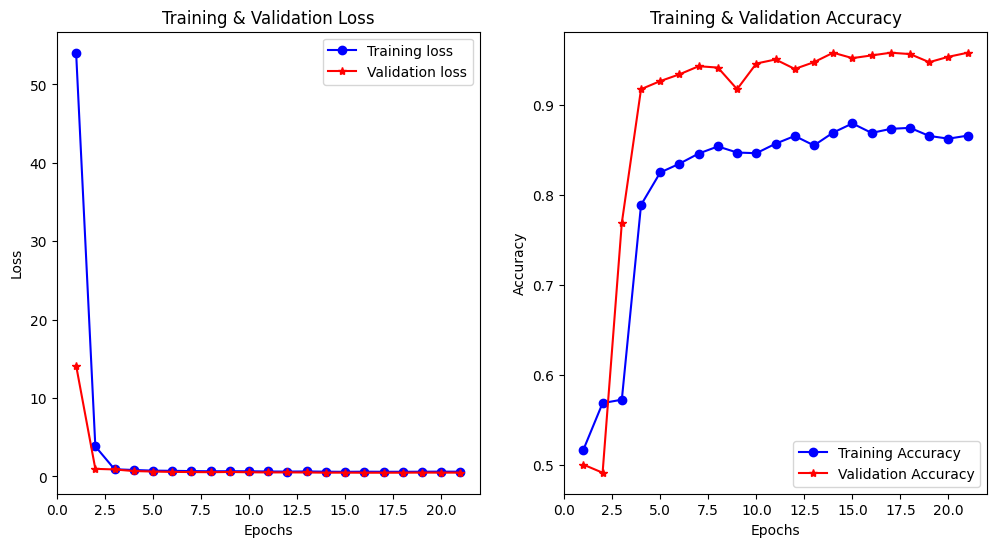

In [29]:
import matplotlib.pyplot as plt

history_dict = history.history

train_loss = history_dict['loss']
val_loss = history_dict['val_loss']

train_acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

epochs = range(1, len(train_loss) + 1)

# График потерь
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'r*-', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

# График точности
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r*-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

plt.show()

In [30]:
from google.colab import files
files.download("fasttext_model_lstm.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# GRU

In [31]:
import keras_tuner as kt

def build_model(hp):
    text_input = Input(shape=(300,), name='text_input')
    activation_choice = hp.Choice('activation', ['relu', 'swish', 'leaky_relu'])

    if activation_choice == 'leaky_relu':
        activation = tf.keras.layers.LeakyReLU(alpha=0.1)
    else:
        activation = activation_choice

    x_text = Dense(hp.Int('dense_units', 16, 128, 16), activation=activation)(text_input)
    x_text = tf.keras.layers.Reshape((x_text.shape[-1], 1))(x_text)

    for i in range(hp.Int('num_gru_layers', 1, 5)):
        x_text = GRU(hp.Int(f'gru_units_{i}', 32, 256, 32), return_sequences=(i < hp.get('num_gru_layers') - 1))(x_text)

    num_input = Input(shape=(4,), name='num_input')
    x_num = Dense(32, activation=activation)(num_input)
    x_num = tf.keras.layers.Reshape((x_num.shape[-1], 1))(x_num)
    x_num = GlobalAveragePooling1D()(x_num)

    combined = Concatenate()([x_text, x_num])
    x = combined

    for i in range(hp.Int('num_layers', 1, 10)):
        reg_type = hp.Choice(f'reg_type_{i}', ['l1', 'l2', 'l1_l2'])
        reg_value = hp.Float(f'reg_value_{i}', 0.001, 0.1, 0.001)

        if reg_type == 'l1':
            reg = regularizers.l1(reg_value)
        elif reg_type == 'l2':
            reg = regularizers.l2(reg_value)
        else:
            reg = regularizers.l1_l2(l1=reg_value, l2=reg_value)

        x = Dense(hp.Int(f'units_{i}', 64, 256, 64), activation=activation, kernel_regularizer=reg)(x)
        x = Dropout(hp.Float(f'dropout_{i}', 0.1, 0.5, 0.1))(x)

    output = Dense(2, activation='softmax')(x)

    optimizer_choice = hp.Choice('optimizer', ['adam', 'adamw', 'rmsprop', 'sgd', 'adadelta', 'adagrad', 'nadam'])
    optimizers = {
        'adam': Adam(), 'adamw': AdamW(), 'rmsprop': RMSprop(),
        'adadelta': Adadelta(), 'adagrad': Adagrad(), 'nadam': Nadam(), 'sgd': SGD()
    }
    optimizer = optimizers[optimizer_choice]

    model = Model(inputs=[text_input, num_input], outputs=output)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Настройка гиперпараметров
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='my_tuner_dir',
    project_name='text_num_classification'
)

# Поиск лучших гиперпараметров
tuner.search(
    [X_train_text, X_train_num], y_train,
    validation_data=([X_test_text, X_test_num], y_test),
    epochs=10,
    batch_size=32,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)

# Получение наилучшей модели
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hps)

# Обучение лучшей модели
history = best_model.fit(
    [X_train_text, X_train_num], y_train,
    validation_data=([X_test_text, X_test_num], y_test),
    epochs=50,
    batch_size=32,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)

# Оценка модели на тестовой выборке
test_loss, test_acc = best_model.evaluate([X_test_text, X_test_num], y_test)
print(f"Тестовая точность: {test_acc:.4f}")

# Сохранение обученной модели
best_model.save("fasttext_model_gru.h5")


Reloading Tuner from my_tuner_dir/text_num_classification/tuner0.json
Epoch 1/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - accuracy: 0.5266 - loss: 79.0382 - val_accuracy: 0.6291 - val_loss: 14.4975
Epoch 2/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - accuracy: 0.5595 - loss: 7.4776 - val_accuracy: 0.5000 - val_loss: 0.9985
Epoch 3/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.6024 - loss: 0.9534 - val_accuracy: 0.8769 - val_loss: 0.8230
Epoch 4/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.7801 - loss: 0.8212 - val_accuracy: 0.9264 - val_loss: 0.6315
Epoch 5/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - accuracy: 0.8248 - loss: 0.7157 - val_accuracy: 0.9324 - val_loss: 0.5936
Epoch 6/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - accuracy: 0.8480 - loss: 0.6827 - val_accuracy: 0.9324 - val_loss: 0.5551
Epoch 7/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - accuracy: 0.8432 - loss: 0.6609 - val_accuracy: 0.9339 - val_loss: 0.5318
Epoch 8/50
84/84 ━━━━━━━━━━━━━━━━━━━━

Тестовая точность: 0.9715


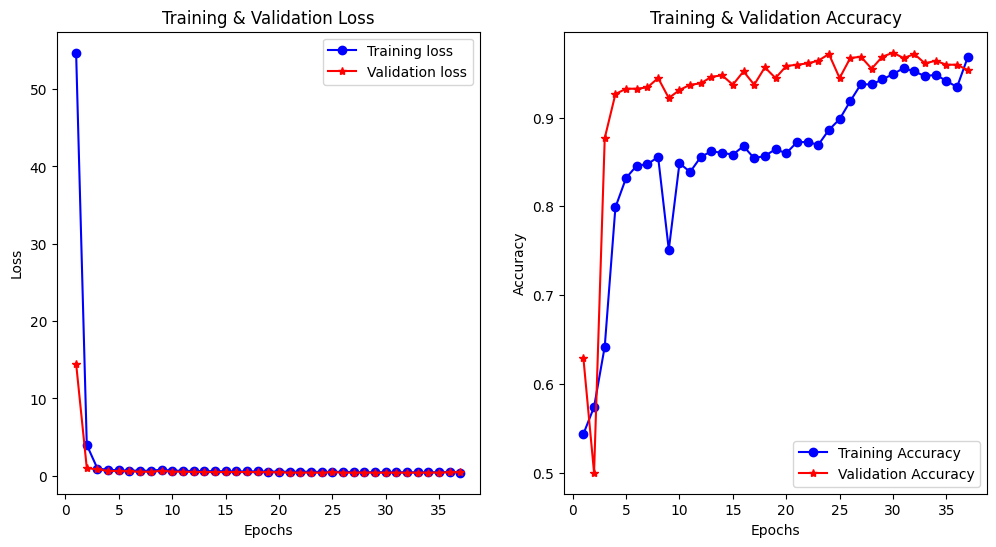

In [32]:
import matplotlib.pyplot as plt

history_dict = history.history

train_loss = history_dict['loss']
val_loss = history_dict['val_loss']

train_acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

epochs = range(1, len(train_loss) + 1)

# График потерь
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'r*-', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

# График точности
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r*-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

plt.show()

In [33]:
from google.colab import files
files.download("fasttext_model_gru.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>